In [2]:

import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score


In [3]:

# Cargar todos los archivos CSV de la variante TCP BBR
csv_files = glob.glob("../data_processed/bbr/*.log.csv")
df = pd.concat([pd.read_csv(f, sep=',') for f in csv_files], ignore_index=True)
df.columns = df.columns.str.strip()
print(df.columns.tolist())   

print(f"Cantidad de registros: {df.shape[0]}")
df.head()

['wscale', 'rto', 'rtt', 'mss', 'pmtu', 'rcvmss', 'advmss', 'cwnd', 'ssthresh', 'bytes_sent', 'bytes_retrans', 'bytes_acked', 'segs_out', 'segs_in', 'data_segs_out', 'lastrcv', 'delivered', 'rcv_space', 'rcv_ssthresh', 'timestamp', 'throughput', 'packets_sent', 'packets_acked', 'packets_lost', 'loss_rate']
Cantidad de registros: 179950


,wscale,rto,rtt,mss,pmtu,rcvmss,advmss,cwnd,ssthresh,bytes_sent,...,lastrcv,delivered,rcv_space,rcv_ssthresh,timestamp,throughput,packets_sent,packets_acked,packets_lost,loss_rate
0,7.7,280,76.279,1448,1500,536,1448,14,52,26064,...,108,19,14480,64088,0.1,275120.0,18.0,19.0,-1.0,0.0
1,7.7,272,69.385,1448,1500,536,1448,4,52,37648,...,216,37,14480,64088,0.2,260640.0,8.0,18.0,-10.0,0.0
2,7.7,240,39.996,1448,1500,536,1448,4,52,63712,...,328,53,14480,64088,0.3,231680.0,18.0,16.0,2.0,0.0
3,7.7,232,28.081,1448,1500,536,1448,14,52,101360,...,436,75,14480,64088,0.4,318560.0,26.0,22.0,4.0,0.0
4,7.7,248,45.456,1448,1500,536,1448,14,52,133216,...,544,91,14480,64088,0.5,231680.0,22.0,16.0,6.0,0.0


In [4]:
# Etiquetar eventos de congestión: caída abrupta en CWND
df['congestion_event'] = (df['cwnd'].diff().shift(-1) < -10).astype(int)
df['congestion_event'].value_counts()


congestion_event
0    179172
1       778
Name: count, dtype: int64

In [5]:
features = [
    'cwnd',           # reacción inmediata del algoritmo TCP a congestión
    'rtt',            # refleja colas y delays
    'bytes_retrans',  # reflejo de pérdidas o eventos dudosos
    'throughput',     # caída de tasa de transmisión puede indicar congestión
    'packets_lost',   # indicador fuerte si TCP tradicional; BBR evita usarlo pero puede reflejar estrés
    'loss_rate',      # Métrica agregada 
]


In [6]:

# Eliminar nulos y preparar datasets
df.dropna(subset=features + ['congestion_event'], inplace=True)

X = df[features]
y = df['congestion_event']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:

model = RandomForestClassifier(
    n_estimators=100,         # 100 árboles para estabilidad
    random_state=42,          # semilla fija 
    class_weight='balanced',  # compensa el desbalance (muy pocos eventos de congestión)
    n_jobs=-1,                # usa todos los núcleos del CPU disponibles
    max_depth=10,             # controla el sobreajuste limitando la profundidad de los árboles
    min_samples_leaf=5        # evita hojas muy pequeñas (ruido) → mejora generalización
)

model.fit(X_train_scaled, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Calcular precisión, recall y thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Calcular F1-score para cada threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# Elegir el threshold que maximiza F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold óptimo (max F1-score): {best_threshold:.2f}")

y_pred_adjusted = (y_probs > best_threshold).astype(int)

Threshold óptimo (max F1-score): 0.93


Reporte de clasificación con threshold ajustado:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35834
           1       0.21      0.13      0.16       156

    accuracy                           0.99     35990
   macro avg       0.60      0.56      0.58     35990
weighted avg       0.99      0.99      0.99     35990



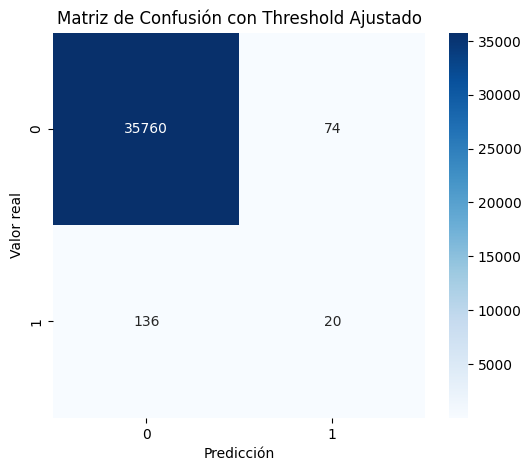

In [9]:

print("Reporte de clasificación con threshold ajustado:")
print(classification_report(y_test, y_pred_adjusted))

# Mostrar nueva matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión con Threshold Ajustado")
plt.show()

In [1]:

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
sns.barplot(x=np.array(features)[indices], y=importances[indices])
plt.xticks(rotation=45)
plt.title("Importancia de cada feature")
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined